In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

from scipy import sparse as sps

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# For scaling: 


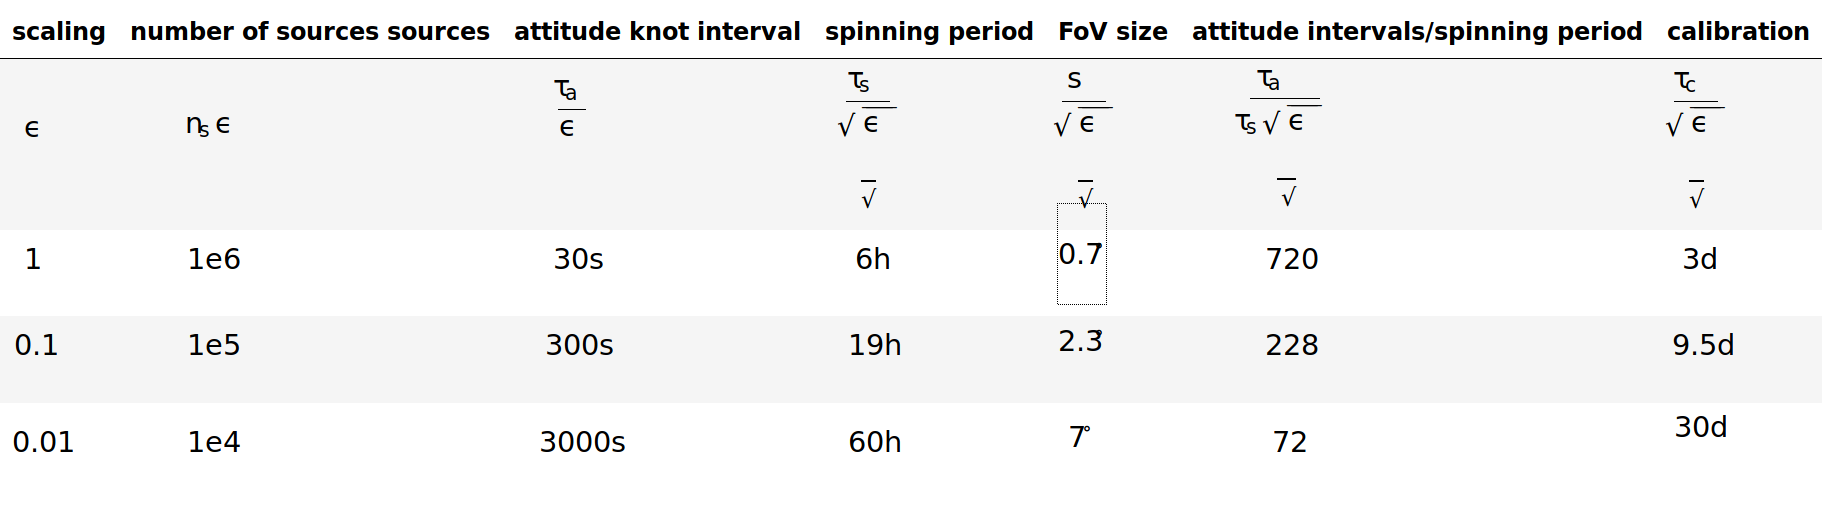

In [2]:
Image('./figures/scaling_factors.png')

# **Initializing objects:**

In [4]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/2
my_dt = 1/24/2 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [5]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(5) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=300  # has to be divisible by 3

Scanner created


# End scanner

In [6]:
# Functions usefull for this bit:
times_for_source = np.linspace(t_init, t_end, num=num_sources, endpoint=True)

def generate_angles_of_sources():
    # Warning be carefull to what you use to get alpha/delta from vector
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) *0
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha +noise[0], a_P+noise[1], a_F+noise[2]]
        deltas += [delta +noise[3], d_P+noise[4], d_F+noise[5]]
    return alphas, deltas


In [7]:
def generate_telescope_positions(num_points = 10000):
    # Generate telescopes positions
    alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
    for t in np.linspace(t_init, t_end, num=num_points):
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas_P.append(a_P-np.pi)
        deltas_P.append(d_P)
        alphas_F.append(a_F-np.pi)
        deltas_F.append(d_F)
    return alphas_P, deltas_P, alphas_F, deltas_F

In [8]:
def transform_twoPi_into_halfPi(deltas):
    deltas = np.array(deltas)
    up_indices = np.where(deltas>np.pi)[0]
    down_indices = np.where(deltas<np.pi)[0]
    deltas[up_indices] -= 2*np.pi
    # deltas[down_indices] += np.pi
    return deltas
    

In [9]:
def add_nans(x,y):
    pos = np.where(np.abs(np.diff(x)) >= 2)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    """pos = np.where(np.abs(np.diff(y)) >= 1)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)"""
    return x, y

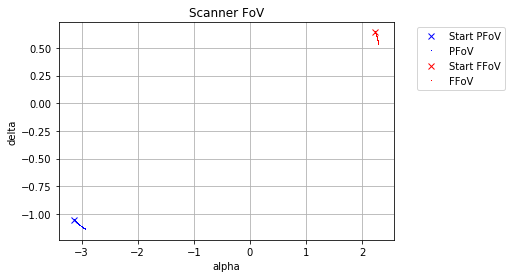

Plotted first plot


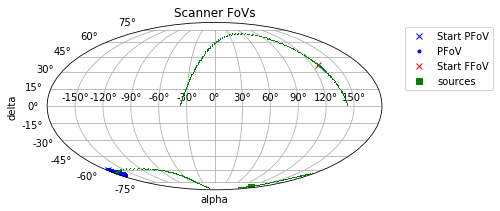

In [10]:
a_min, a_max = (0,100)
alphas, deltas = generate_angles_of_sources()
alphas_P, deltas_P, alphas_F, deltas_F = generate_telescope_positions()

deltas_P = transform_twoPi_into_halfPi(deltas_P)
deltas_F = transform_twoPi_into_halfPi(deltas_F)
fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='FFoV')

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')"""

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

print('Plotted first plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b.', label='PFoV', alpha=1, linestyle="None", linewidth=0)
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
# plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker='.')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker=',')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')

plt.title("Scanner FoVs")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig('./figures/tmp/Mollweide_scanner_positions')

In [11]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 10, 10, 10, 10))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# **Scan**

In [12]:
obs_times = []
calc_sources = []
real_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
    print('------------------------------------------------------')
sources = real_sources
obs_times = list(np.sort(obs_times))

Starting scan with time from 0 to 0.5 days
Total measured time: 0.016654253005981445
zetas: [-0.0015200864457320558, -0.0038852340447772193, -0.005697281256196643, -0.00791960307296718]
etas: [1.1102230246251565e-16, -5.551115123125783e-16, 5.551115123125783e-16, 3.3306690738754696e-16]
times: [0.03697882922704204, 0.21301945932240207, 0.2869772128260399, 0.46301551149053377]
How many observation time?  4
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013888359069824219
zetas: [-2.5560028163451598e-08, -0.005346730298787905, -0.016025847725699247, -0.02134872229606199, -0.03196928623799277]
etas: [0.0, 2.220446049250313e-16, -3.3306690738754696e-16, 1.1102230246251565e-16, -5.551115123125783e-16]
times: [1.1606912820027583e-09, 0.07395845485590774, 0.2499976288411218, 0.32395639353978684, 0.49999080307103827]
How many observation time?  5
Error:  -1.1102230246251565e-16
------------

Total measured time: 0.012790441513061523
zetas: [-0.002394217299437294, -0.008927361538985504, -0.012495244624488576, -0.018906927475588736]
etas: [3.3306690738754696e-16, -4.440892098500626e-16, 9.992007221626409e-16, 3.3306690738754696e-16]
times: [0.052030224528301854, 0.22806896456999642, 0.302026666134426, 0.4780607482285095]
How many observation time?  4
Error:  3.0531133177191805e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012814760208129883
zetas: [-2.5567189170461682e-08, -0.0057370591347588925, -0.01737306396766038, -0.023109138185216517]
etas: [0.0, 1.1102230246251565e-16, -5.551115123125783e-16, 6.661338147750939e-16]
times: [0.015050168624261343, 0.08900971114362931, 0.2650505296172528, 0.3390110827302658]
How many observation time?  4
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01216530

Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01359868049621582
zetas: [-2.5476401419033398e-08, 0.00023010805492103032, -0.0004912592555975303, -0.00011516377273730955]
etas: [1.1102230246251565e-16, -2.220446049250313e-16, -1.1102230246251565e-16, 4.440892098500626e-16]
times: [0.028428093335075788, 0.20447000601577914, 0.27842853119872585, 0.4544697186500179]
How many observation time?  4
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01404881477355957
zetas: [-0.0030533790784243115, -0.01274985587636098, -0.017654857855470493, -0.02726795783537035]
etas: [1.1102230246251565e-16, -1.1102230246251565e-16, -3.3306690738754696e-16, 2.220446049250313e-16]
times: [0.06707993957653972, 0.24311905076737844, 0.3170774402545124, 0.49311310783222323]
How many observation time?  4
Error:

Error:  8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012799501419067383
zetas: [-2.5528660331508582e-08, -0.004918994922768603, -0.014647980647542014, -0.01959977770837931]
etas: [-1.1102230246251565e-16, 0.0, -5.551115123125783e-16, 2.220446049250313e-16]
times: [0.03846153983698009, 0.11242105536086258, 0.28846503034289955, 0.36242731418887836]
How many observation time?  4
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01315164566040039
zetas: [-2.5477657816797006e-08, -0.002804928719856656, -0.004801851780567341, -0.007465496462416476]
etas: [0.0, -3.3306690738754696e-16, -2.220446049250313e-16, 5.551115123125783e-16]
times: [0.03846153851388497, 0.21450282489717373, 0.28846070927769846, 0.46449946990484764]
How many observation time?  4
Error:  0.0
--------------------------------

times: [0.050167225263392394, 0.1241261020260897, 0.30017077488815286, 0.37413274638051963]
How many observation time?  4
Error:  -8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012317895889282227
zetas: [-2.5492621263945026e-08, -0.006061140743393642, -0.009429867711296861, -0.01536630313427832]
etas: [-1.1102230246251565e-16, -1.1102230246251565e-16, 5.551115123125783e-16, -2.220446049250313e-16]
times: [0.050167224550133734, 0.2262071161921539, 0.30016506716710756, 0.47620058729544384]
How many observation time?  4
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012694597244262695
zetas: [0.0022822077591102565, -0.0034543805976789506, -0.015089029603276398, -0.02082436347206988]
etas: [0.0, -3.3306690738754696e-16, 1.1102230246251565e-16, -4.440892098500626e-16]
times: [0.01485938137720

Total measured time: 0.01227879524230957
zetas: [-2.5442706746980906e-08, -0.0018369861864415418, -0.004260602132752897, -0.006156836189465005]
etas: [3.3306690738754696e-16, 2.220446049250313e-16, 5.551115123125783e-16, 3.3306690738754696e-16]
times: [0.06856187359539968, 0.14252088108640817, 0.31856473097925864, 0.3925248773142514]
How many observation time?  4
Error:  3.608224830031759e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012319803237915039
zetas: [-2.5530893621450452e-08, -0.009935334489702121, -0.014941757134390261, -0.024798788084152177]
etas: [0.0, -2.220446049250313e-16, 1.1102230246251565e-16, -1.1102230246251565e-16]
times: [0.06856187394201409, 0.2446021305292673, 0.31856066644027814, 0.49459763164491]
How many observation time?  4
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.0123326

times: [0.0063072834542082495, 0.08026755981227832, 0.2563086787447744, 0.3302677283706425]
How many observation time?  4
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01250767707824707
zetas: [0.0016174577228571156, -0.0027923677257658034, -0.011319005922721953, -0.01576972304090019]
etas: [1.1102230246251565e-16, 1.1102230246251565e-16, -5.551115123125783e-16, 0.0]
times: [0.044960816360803464, 0.11891936320326085, 0.2949636261574606, 0.36892530545414004]
How many observation time?  4
Error:  -8.326672684688674e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012340784072875977
zetas: [-2.5427404792832682e-08, -0.00012448063714444577, 0.001524622053303227, 0.0013388665509979298]
etas: [-2.220446049250313e-16, 3.3306690738754696e-16, 3.3306690738754696e-16, 3.3306690738754696e-16]
times: [0.0819397995575364, 0.15589863411312

Total measured time: 0.012923240661621094
zetas: [0.005553044377569977, -2.5555162042056875e-08, -0.0112177627870379, -0.016786852976142526]
etas: [0.0, 1.1102230246251565e-16, 4.440892098500626e-16, -3.3306690738754696e-16]
times: [0.026376125418464156, 0.10033444961334441, 0.2763771016181018, 0.3503376512554224]
How many observation time?  4
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012893199920654297
zetas: [0.0005487779606071485, -0.0017248062089331429, -0.005186777189765973, -0.007518067334980187]
etas: [0.0, 2.220446049250313e-16, 7.771561172376096e-16, -3.3306690738754696e-16]
times: [0.06502734172602519, 0.13898621780758696, 0.31503015630104864, 0.38899062398285644]
How many observation time?  4
Error:  1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01265573501586914
zetas: [

Total measured time: 0.013679981231689453
zetas: [0.004125410939593518, -2.5518346075115165e-08, -0.007853538859053493, -0.01202346642984551]
etas: [1.1102230246251565e-16, 1.1102230246251565e-16, -5.551115123125783e-16, 1.1102230246251565e-16]
times: [0.048115744888746335, 0.122073579825547, 0.2981172327114922, 0.37207822173539334]
How many observation time?  4
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012904644012451172
zetas: [-0.0008331786346512845, -0.0003429784120315087, 0.0027709364840703514, 0.0032008471873893884]
etas: [-1.1102230246251565e-16, -1.1102230246251565e-16, 1.1102230246251565e-16, -7.771561172376096e-16]
times: [0.08676644827629014, 0.16072518754112824, 0.33676737691510283, 0.4107250585058759]
How many observation time?  4
Error:  -2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total m

Total measured time: 0.012716054916381836
zetas: [-0.0019771298916391932, 0.0008018775590973964, 0.00937963773816571, 0.012111647149146004]
etas: [0.0, 4.440892098500626e-16, -1.1102230246251565e-16, -2.220446049250313e-16]
times: [0.10683325444275597, 0.18079196416563315, 0.3568330519762943, 0.4307890605976198]
How many observation time?  4
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012781143188476562
zetas: [-2.553947209271712e-08, 0.004529444253011942, 0.01733514222876467, 0.021868639254115592]
etas: [-2.220446049250313e-16, 3.3306690738754696e-16, -6.661338147750939e-16, 1.1102230246251565e-16]
times: [0.1438127076005095, 0.21777112554771835, 0.39381441111861465, 0.46777180724959044]
How many observation time?  4
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.01265215873

In [13]:
print('t_end: ', t_end)
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

t_end:  0.5


In [14]:
my_scanner.obs_times_FFoV

[0.09159306822813748, 0.34159355891104176]

In [15]:
my_scanner.obs_times_PFoV

[0.16555183934897627, 0.4155507575286603]

# **2- Combine with solver:**

In [16]:
obs_times

[1.1606912820027583e-09,
 0.0012916158643186187,
 0.001481615769096281,
 0.0016722396790403242,
 0.0016722419991418167,
 0.0029631815803116326,
 0.0031530787548510347,
 0.003344480520849037,
 0.0033444828354035516,
 0.004635105954533414,
 0.004824893787573823,
 0.005016721364648325,
 0.00501672366942605,
 0.0063072834542082495,
 0.00649698405336675,
 0.0066889622103499195,
 0.006688964501163542,
 0.00797962952352985,
 0.008169280238597572,
 0.008361203057864041,
 0.008361205330574386,
 0.009652080846872354,
 0.009841719389531541,
 0.010033443907099433,
 0.010033446157621183,
 0.011324593588636201,
 0.011514246235648822,
 0.011705684757963618,
 0.011705686982270454,
 0.012997133757749552,
 0.013186813365745287,
 0.013377925610362886,
 0.013377927804492548,
 0.014669672646671348,
 0.014859381377204571,
 0.015050166464202432,
 0.015050168624261343,
 0.016342186843300934,
 0.016531919000290086,
 0.016722407319386456,
 0.01672240944155421,
 0.018014658305110478,
 0.01820440319917468,
 0.018

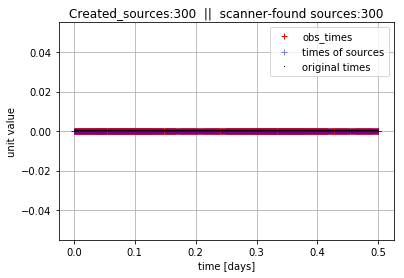

(None, <matplotlib.legend.Legend at 0x7fbb767fad30>, None)

In [17]:
plt.figure()
 
plt.title('Created_sources:'+str(num_sources)+'  ||  scanner-found sources:'+str(len(calc_sources)))

plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')

plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b+', label='times of sources', alpha=0.5)

sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')

plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show()

#bins: 24


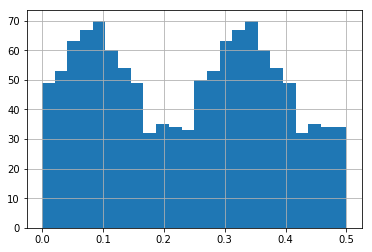

In [18]:
bins = int((t_end-t_init)/my_dt)
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.grid();


In [19]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [20]:
print('Updating only sources:')
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources:


In [21]:
Solver.error_function()

0.0

In [22]:
# Solver.reset_iterations()
#Solver.iterate(1)

# *Update Attitude*

In [23]:
if len(sources) != len(calc_sources):
    raise ValueError('there must be the same number of real and calc sources')

In [24]:
print('Updating attitude')
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

Updating attitude


In [25]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
last_coef = 4
#Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  0.0
c_noise shape:  (4, 25)
Error after Noise:  0.0


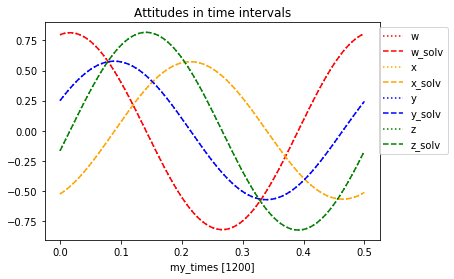

In [26]:
compare_attitudes(gaia, Solver, obs_times)

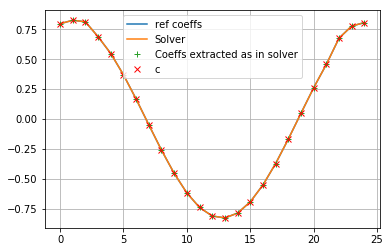

(None, <matplotlib.legend.Legend at 0x7fbb73d15c88>, None)

In [27]:
to_fit = gaia.s_w
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
a_ref = to_fit.get_coeffs()
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

**Plot matrices:**

In [28]:
if (Solver.att_knots.shape[0] - Solver.att_coeffs.shape[1]) != 4:
    raise ValueError('there should be 4 coeffs less than the number of knots')

In [29]:
N_aa = Solver.compute_attitude_LHS()

N_aa_dim: 25


In [30]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

N_aa_w.shape (25, 25)
N_aa_z.shape (25, 25)


In [31]:
obs_times

[1.1606912820027583e-09,
 0.0012916158643186187,
 0.001481615769096281,
 0.0016722396790403242,
 0.0016722419991418167,
 0.0029631815803116326,
 0.0031530787548510347,
 0.003344480520849037,
 0.0033444828354035516,
 0.004635105954533414,
 0.004824893787573823,
 0.005016721364648325,
 0.00501672366942605,
 0.0063072834542082495,
 0.00649698405336675,
 0.0066889622103499195,
 0.006688964501163542,
 0.00797962952352985,
 0.008169280238597572,
 0.008361203057864041,
 0.008361205330574386,
 0.009652080846872354,
 0.009841719389531541,
 0.010033443907099433,
 0.010033446157621183,
 0.011324593588636201,
 0.011514246235648822,
 0.011705684757963618,
 0.011705686982270454,
 0.012997133757749552,
 0.013186813365745287,
 0.013377925610362886,
 0.013377927804492548,
 0.014669672646671348,
 0.014859381377204571,
 0.015050166464202432,
 0.015050168624261343,
 0.016342186843300934,
 0.016531919000290086,
 0.016722407319386456,
 0.01672240944155421,
 0.018014658305110478,
 0.01820440319917468,
 0.018

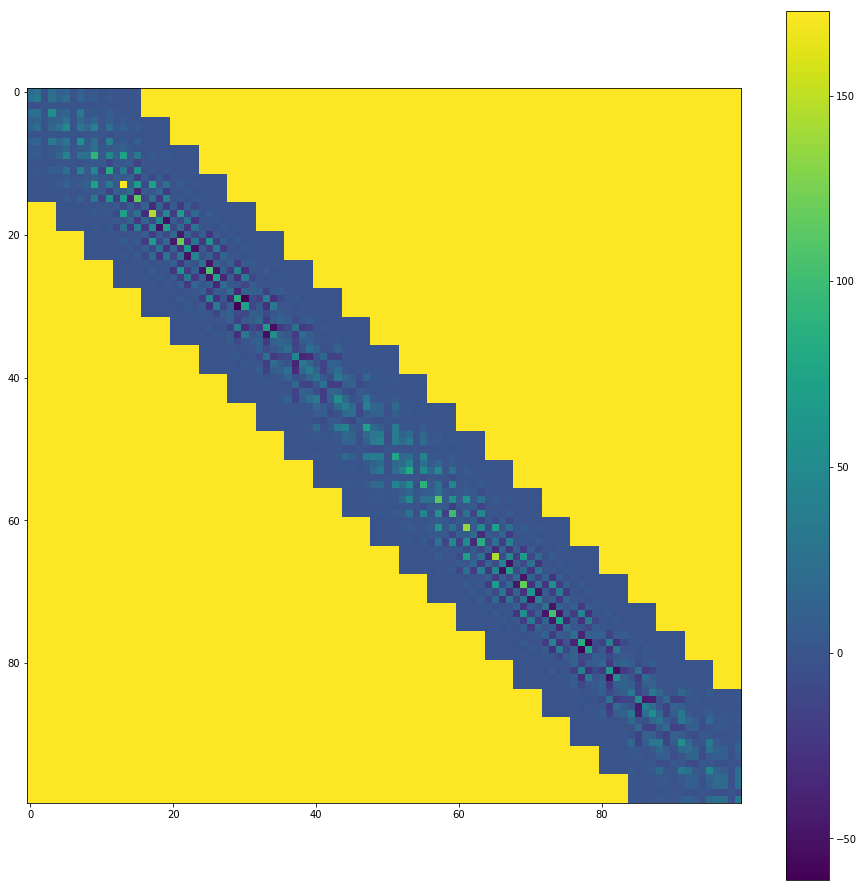

In [32]:
A=N_aa
plt.figure(figsize=(16,16))
threshold = 0
A[np.where(A==threshold)] = A.max()
plt.imshow(A, vmin=None, vmax=None)
plt.colorbar()
#fig.colorbar(plot1, ax=plt)

Text(0.5, 0.98, 'Matrix visualization')

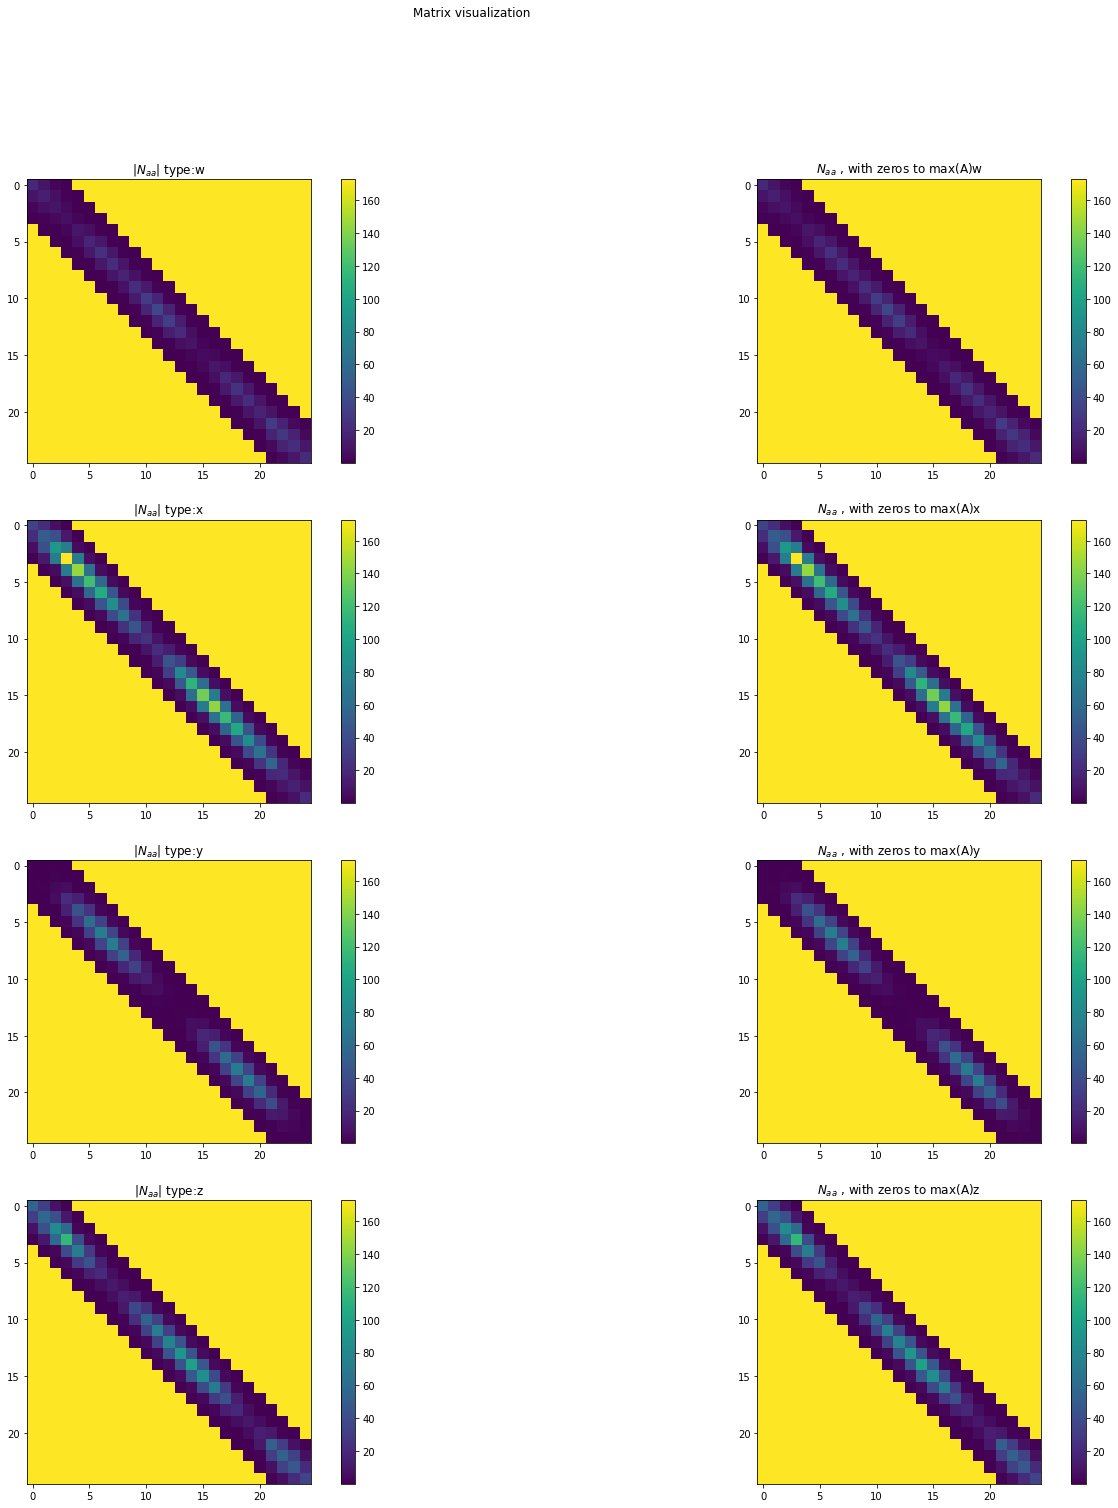

In [33]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=None)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
# plt.show()

In [34]:
Solver.att_coeffs.shape

(4, 25)

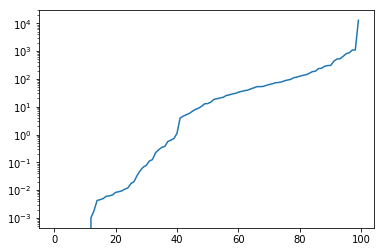

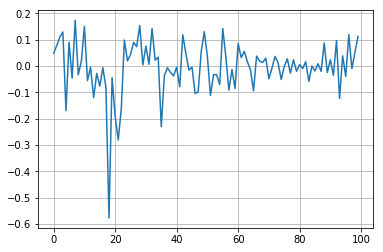

In [35]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals, label=type_list[i])
    
plt.yscale('log')
#plt.xlim(0,5)
plt.show()


plt.plot(eig_vecs[0])
#plt.xlim(100,110)
plt.grid()
plt.show()

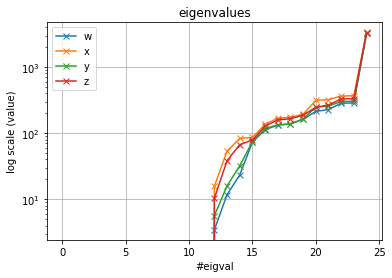

In [36]:
for i, Naa in enumerate(N_aa_list):
    eig_vals, eig_vecs = np.linalg.eigh(Naa)
    plt.plot(eig_vals, label=type_list[i],marker='x')
    if not helpers.check_symmetry(Naa):
        raise ValueError('Matrix not symmetric')
    # print('Condition number: ', np.linalg.cond(Naa))
    # print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
    # print('Rank: ', np.linalg.matrix_rank(Naa, hermitian=True))
    # print('det(N_aa):', np.linalg.det(Naa),'\n')
plt.yscale('log'), plt.legend(), plt.grid()
plt.title('eigenvalues'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval')
# plt.xlim((0,5))

plt.show()

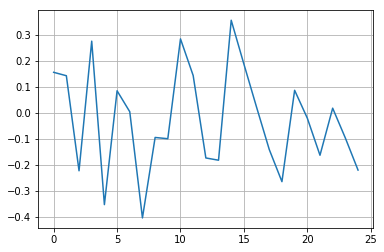

In [37]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa_list[2])
plt.plot(eig_vecs[0])
plt.grid()

# **See iterations**

In [ ]:
sps.spdiags()

In [55]:
half_band = np.array([[1.2,2,3.5], [4,5,6], [1,2,3],[1,2,0],[4,0,0]])
print(half_band)
helpers.get_sparse_diagonal_matrix_from_half_band(half_band).toarray()

[[1.2 2.  3.5]
 [4.  5.  6. ]
 [1.  2.  3. ]
 [1.  2.  0. ]
 [4.  0.  0. ]]
[ 0 -1 -2]


array([[1.2, 2. , 3.5, 0. , 0. ],
       [2. , 4. , 5. , 6. , 0. ],
       [3.5, 5. , 1. , 2. , 3. ],
       [0. , 6. , 2. , 1. , 2. ],
       [0. , 0. , 3. , 2. , 4. ]])

***** Iteration: 2 *****
N_aa_dim: 25
attitude error: 0.047627332086150914
Error after iteration: 1.9427078284598835e-06


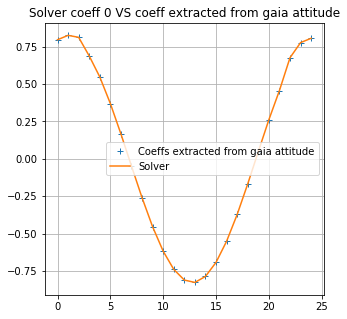

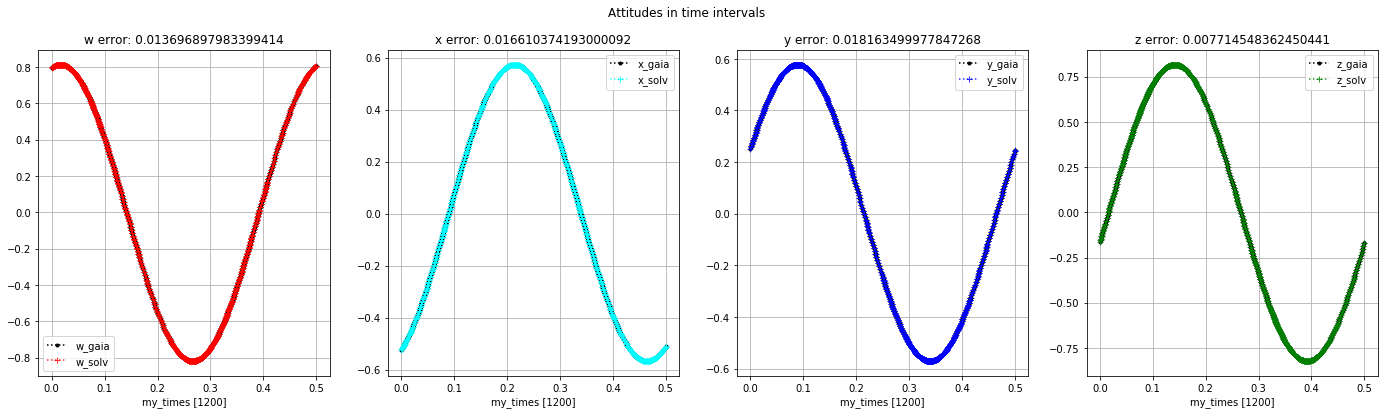

MAGNITUDE: 1.0000257837109179


In [40]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted from gaia attitude')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.title('Solver coeff 0 VS coeff extracted from gaia attitude')
plt.grid(), plt.legend(), plt.show()
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)
fig2.savefig('lala.png')

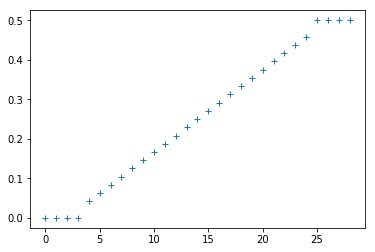

In [39]:
plt.plot(Solver.att_knots, '+')
plt.show()

In [81]:
Solver.iterate(100)

***** Iteration: 3 *****
N_aa_dim: 121


KeyboardInterrupt: 

In [ ]:
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)


In [61]:
B = A.copy()
A = Solver.compute_attitude_LHS()
print((B-A).sum())

N_aa_dim: 25
-2793.8023511538568


In [62]:
hi = h
h = Solver.compute_attitude_RHS()
print((hi-h).sum())

-9.217095069543289e-12
